# Exercise 02
## Lars Kühmichel, Nicolas Wolf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
class AR_model():
    def __init__(self, p, data):
        self.data = data
        self.T = len(self.data)
        self.p = p
        self.a = self.estimate_parameters()
        
    def estimate_parameters(self):
        X_p = np.ones(shape=(self.T-self.p, self.p+1))
        for i in range(self.p):
            X_p[:, self.p-i] = self.data[i:self.T-self.p+i]
        X_T = self.data[self.p:]
        return np.linalg.inv(X_p.T.dot(X_p)).dot(X_p.T).dot(X_T)

    def predict_next(self, n, initial_x_values):
        predicted_values = np.zeros(len(initial_x_values) + n)
        predicted_values[:p] = initial_x_values
        
        for j in range(n):
            sum = self.a[0]
            for i in range(1, self.p+1):
                sum += self.a[i]*predicted_values[p+j-i]
            predicted_values[p+j] = sum
        
        return predicted_values[p:]
    
def acorr(ts, max_lag):
    lags = np.arange(max_lag)
    result = np.zeros(lags.shape)
    mean_ts = ts.mean()
    T = len(ts)
    gamma_0 = 1/T * np.sum((ts-mean_ts)**2)
    for i, tau in enumerate(lags):
        if tau == 0:
            gamma_tau = gamma_0
        else:
            gamma_tau = 1/(T-tau) * np.sum((ts[:-tau]-mean_ts) * (ts[tau:]-mean_ts))
        result[i] = gamma_tau / gamma_0
    return lags, result

def pacorr(ts, max_order):
    orders = np.arange(1, max_order)
    pacorr_estimates = np.zeros(len(orders))
    for p in orders:
        ar_model = AR_model(p, ts)
        pacorr_estimates[p-1] = ar_model.a[-1]
    return orders, pacorr_estimates

## Task 1

First load and examine the data:

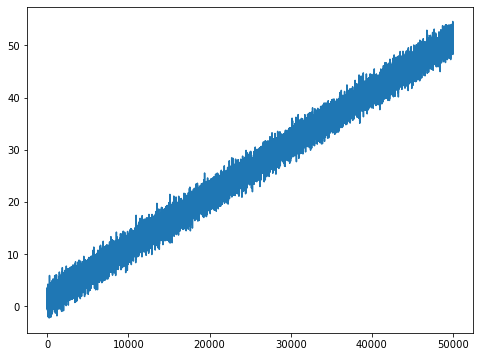

In [3]:
data = np.loadtxt("Tut2_file1.txt")
plt.figure(figsize=(8,6))
plt.plot(data)
plt.show()

### a) Estimate the coefficiets $[a_0, a_1]$ of an AR(1) process from this series using linear regression. Why do you obtain this specific value for $a_1$, and how does it relate to the properties of the time series?

An AR(1) process is defined as:

$$
x_t = a_0 + a_1 x_{t-1} + \epsilon_t
$$

Estimate the coefficients with Linear Regression:

In [4]:
def linear(x, a0, a1):
    return a0 + a1*x
popt, pcov=curve_fit(linear, data[:-1], data[1:], p0=[0,0])
print(popt, "+-", np.sqrt(np.diag(pcov)))

T = len(data)
p = 1
X_p = np.ones(shape=(T-p, p+1))
X_p[:, 1] = data[0:T-p]
X_T = data[p:]

a_p = np.linalg.inv(X_p.T.dot(X_p)).dot(X_p.T).dot(X_T)
print(a_p)

ar1 = AR_model(1, data)
print(ar1.a)


[0.0790823  0.99702754] +- [0.01033242 0.00034465]
[0.0790823  0.99702754]
[0.0790823  0.99702754]


## b) Detrend the time series by performing linear regression on time and repeat the analysis above. How does the coefficient (and the AR process) change?

[1.24528351e+00 1.00007021e-03] +- [1.12145543e-02 3.88489385e-07]


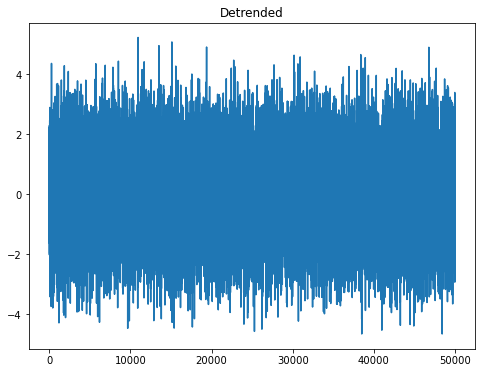

In [5]:
x_values = np.arange(len(data))
popt, pcov=curve_fit(linear, x_values, data, p0=[0,0])
print(popt, "+-", np.sqrt(np.diag(pcov)))

data_detrended = data - linear(x_values, *popt)

plt.figure(figsize=(8,6))
plt.plot(data_detrended)
plt.title("Detrended")
plt.show()

In [6]:
ar1_detrended = AR_model(1, data_detrended)
print(ar1_detrended.a)

[5.16851727e-05 6.02895814e-01]


The constant coefficient is now close to zero

## c) Generate predictions from your estimated AR(1) model up to five time steps ahead. How well do they agree with the true signal? What is the error for one-step ahead prediction as compared to five step ahead predictions?

1.5632531417958402
1.572061916893715


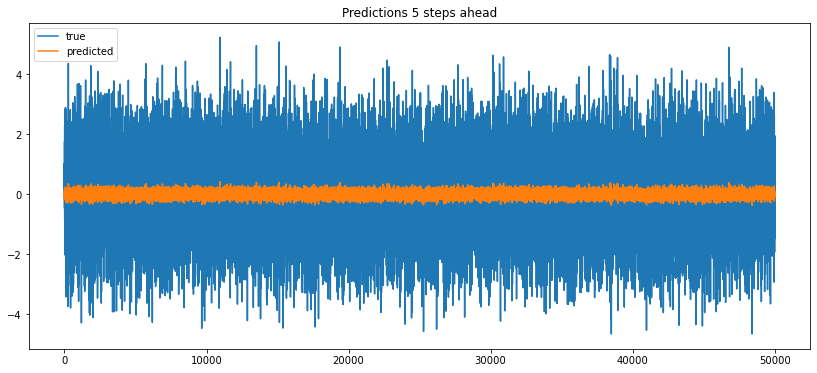

In [7]:
predictions = np.array([ar1_detrended.predict_next(5, np.array([data_detrended[i]]))[-1] for i in range(len(data_detrended)-5)])
squared_residuals = np.square(predictions - data_detrended[5:])
error = np.mean(squared_residuals)
print(error)
print(data_detrended.std()**2)
plt.figure(figsize=(14,6))
plt.plot(data_detrended[5:], label="true")
plt.plot(predictions, label="predicted")
plt.title("Predictions 5 steps ahead")
plt.legend()
plt.show()

1.000650992630251
1.572061916893715


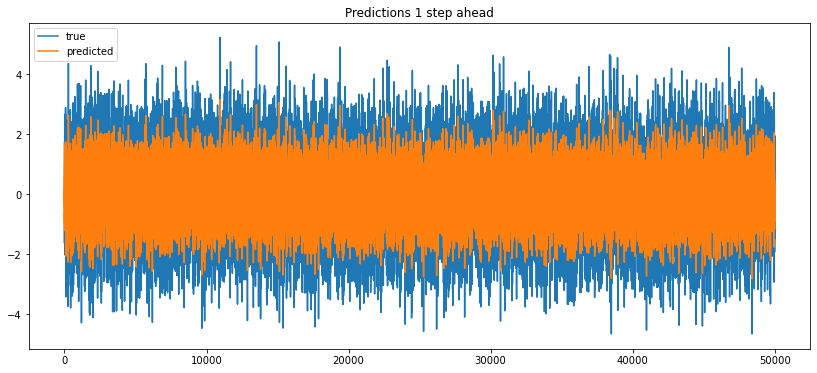

In [8]:
predictions = np.array([ar1_detrended.predict_next(1, np.array([data_detrended[i]]))[-1] for i in range(len(data_detrended)-1)])
squared_residuals = np.square(predictions - data_detrended[1:])
error = np.mean(squared_residuals)
print(error)
print(data_detrended.std()**2)
plt.figure(figsize=(14,6))
plt.plot(data_detrended[1:], label="true")
plt.plot(predictions, label="predicted")
plt.title("Predictions 1 step ahead")
plt.legend()
plt.show()

When predicting 5 steps ahead, the predicted values are close to the mean and the error is thus close to the variance of the time series.

If only the next value is predicted, the results are much closer to the time series

## Task 2: Estimating an AR(1) model

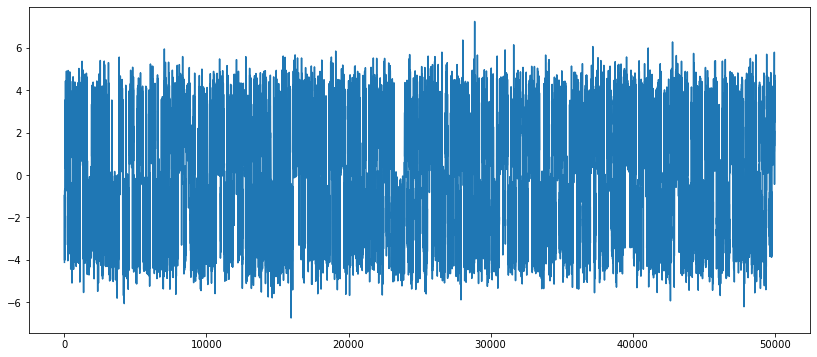

In [9]:
data2 = np.loadtxt("Tut2_file2.txt")
plt.figure(figsize=(14,6))
plt.plot(data2)
plt.show()

[0.00141641 0.87313166]
3.104838898587783
6.354885481315931


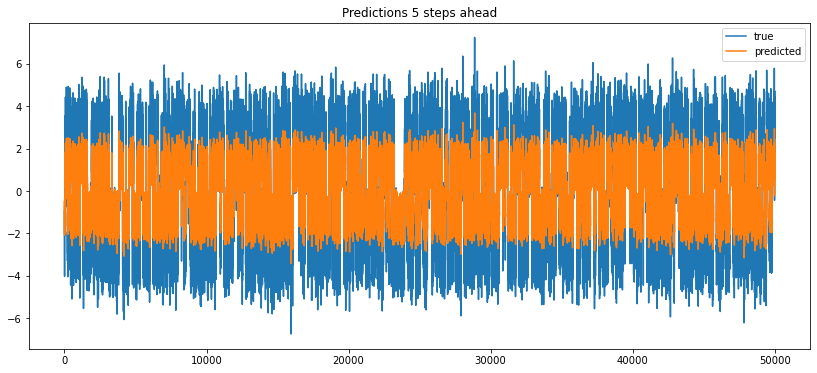

1.5099726800678228
6.354885481315931


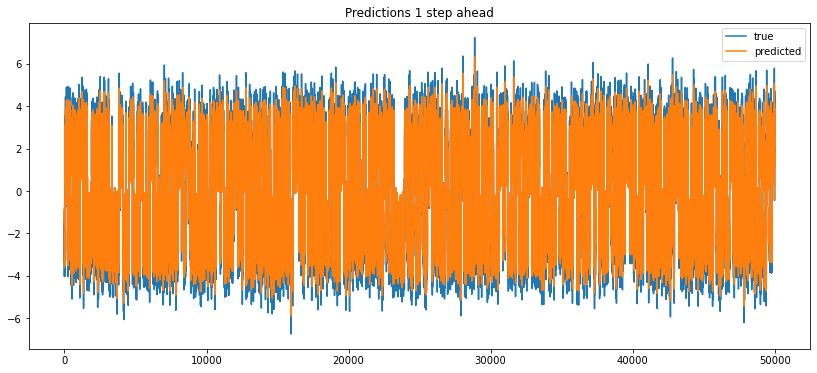

In [10]:
ar1_model_2 = AR_model(1, data2)
print(ar1_model_2.a)

predictions = np.array([ar1_model_2.predict_next(5, np.array([data2[i]]))[-1] for i in range(len(data2)-5)])
squared_residuals = np.square(predictions - data2[5:])
error = np.mean(squared_residuals)
print(error)
print(data2.std()**2)
plt.figure(figsize=(14,6))
plt.plot(data2[5:], label="true")
plt.plot(predictions, label="predicted")
plt.title("Predictions 5 steps ahead")
plt.legend()
plt.show()

predictions = np.array([ar1_model_2.predict_next(1, np.array([data2[i]]))[-1] for i in range(len(data2)-1)])
squared_residuals = np.square(predictions - data2[1:])
error = np.mean(squared_residuals)
print(error)
print(data2.std()**2)
plt.figure(figsize=(14,6))
plt.plot(data2[1:], label="true")
plt.plot(predictions, label="predicted")
plt.title("Predictions 1 step ahead")
plt.legend()
plt.show()

### Is a linear time series model suitable for this type of signal?

We can answer this by looking at the partial autocorrelation. Evidently, there is still significant autocorrelation beyond a lag of 1, so AR(1) is not sufficient. AR(5) or AR(6) seems more appropriate.

In [11]:
lags, acorr_result = acorr(data2, 300)
orders, pacorr_result = pacorr(data2, 20)
print(pacorr_result)

[ 0.87313166  0.29643861  0.1620002   0.08723988  0.05825873  0.02770083
  0.01997528  0.00914872  0.007305    0.00256982 -0.00211136 -0.00366799
  0.00809783 -0.00361211  0.00836824  0.0016384  -0.0038081   0.0013439
 -0.0032373 ]


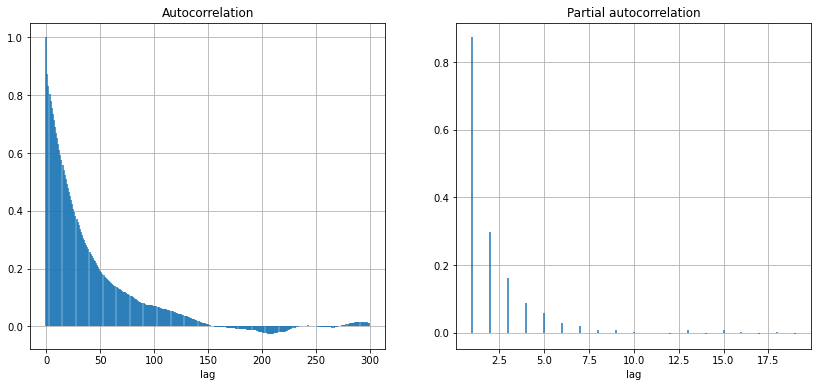

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))
axes[0].vlines(lags, [0], acorr_result)
axes[0].set_xlabel("lag")
axes[0].grid()
axes[0].set_title("Autocorrelation")

axes[1].vlines(orders, [0], pacorr_result)
axes[1].set_xlabel("lag")
axes[1].grid()
axes[1].set_title("Partial autocorrelation")

plt.show()

### Plot the signal in various ways, and examine the autocorrelations in the residuals.

Here are the first, 5th and 30th return maps. We can see several clusters forming.

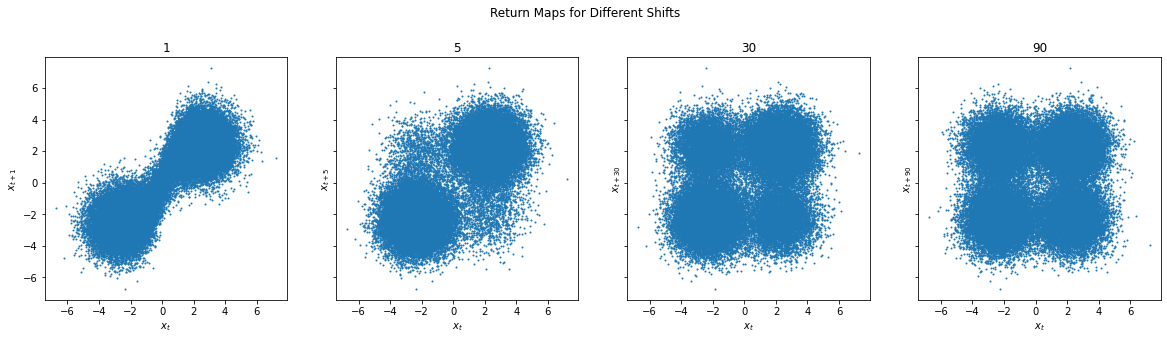

In [13]:
def return_map(x, n):
    ax = plt.gca()
    ax.scatter(x[:-n], x[n:], s=1)
    ax.set_xlabel(r"$x_t$")
    ax.set_ylabel(rf"$x_{{t+{n}}}$")
    ax.set_title(f"{n}")
    ax.set_aspect("equal")

fig, axes = plt.subplots(1, 4, sharex="all", sharey="all", figsize=(20, 5))
plt.sca(axes[0])
return_map(data2, 1)
plt.sca(axes[1])
return_map(data2, 5)
plt.sca(axes[2])
return_map(data2, 30)
plt.sca(axes[3])
return_map(data2, 90)
fig.suptitle("Return Maps for Different Shifts")
plt.show()

### Examine the autocorrelations in the residuals

First, calculate the residuals, then examine the autocorrelation. There is significant autocorrelation only for a lag of 1.

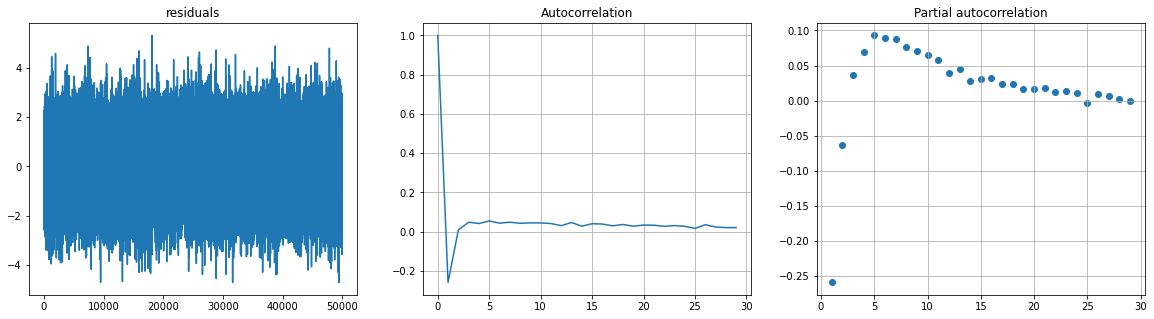

In [14]:
predictions = np.array([ar1_model_2.predict_next(1, np.array([data2[i]]))[-1] for i in range(len(data2)-1)])
residuals = predictions - data2[1:]
lags, acorr_result = acorr(residuals, 30)
orders, pacorr_result = pacorr(residuals, 30)

fig, axes = plt.subplots(1, 3, figsize=(20,5))
axes[0].plot(residuals)
axes[0].set_title("residuals")

axes[1].plot(lags, acorr_result)
axes[1].grid()
axes[1].set_title("Autocorrelation")

axes[2].scatter(orders, pacorr_result)
axes[2].grid()
axes[2].set_title("Partial autocorrelation")

plt.show()

## Task 3 Autocorrelation and Partial Autocorrelation

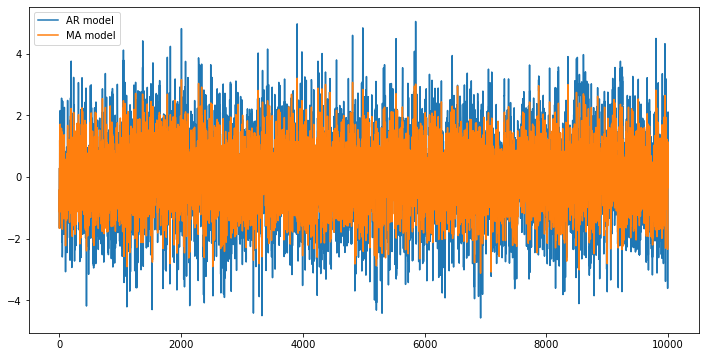

In [15]:
x_AR, x_MA = np.loadtxt("Tut2_file3.txt", skiprows=True).T

plt.figure(figsize=(12,6))
plt.plot(x_AR, label="AR model")
plt.plot(x_MA, label="MA model")
plt.legend()
plt.show()

In [16]:
lags_AR, acorr_AR = acorr(x_AR, 20)
lags_MA, acorr_MA = acorr(x_MA, 20)

orders_AR, pacorr_AR = pacorr(x_AR, 20)
orders_MA, pacorr_MA = pacorr(x_MA, 20)

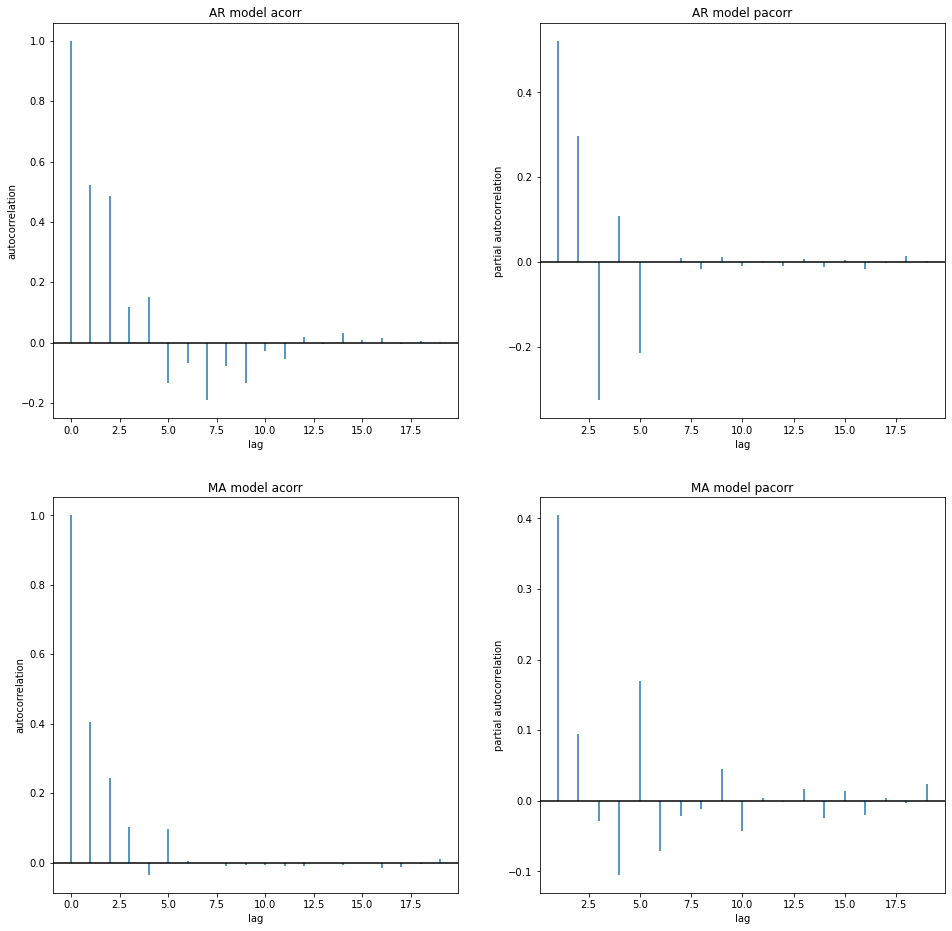

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(16,16))

axes[0, 0].vlines(lags_AR, [0], acorr_AR)
axes[0, 0].axhline(y=0, c='k')
axes[0, 0].set_title("AR model acorr")
axes[0, 0].set_ylabel("autocorrelation")
axes[0, 0].set_xlabel("lag")

axes[0, 1].vlines(orders_AR, [0], pacorr_AR)
axes[0, 1].axhline(y=0, c='k')
axes[0, 1].set_title("AR model pacorr")
axes[0, 1].set_ylabel("partial autocorrelation")
axes[0, 1].set_xlabel("lag")

axes[1, 0].vlines(lags_MA, [0], acorr_MA)
axes[1, 0].axhline(y=0, c='k')
axes[1, 0].set_title("MA model acorr")
axes[1, 0].set_ylabel("autocorrelation")
axes[1, 0].set_xlabel("lag")

axes[1, 1].vlines(orders_MA, [0], pacorr_MA)
axes[1, 1].axhline(y=0, c='k')
axes[1, 1].set_title("MA model pacorr")
axes[1, 1].set_ylabel("partial autocorrelation")
axes[1, 1].set_xlabel("lag")

plt.show()

To determine the order of the AR-process, we have to look at the pacorr-plot and find the lag after which it drops to zero. For the MA-process, the order is the lag after which the acorr drops to zero. In both cases, the order is 5.